## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA

import math
import warnings as w
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [301]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [302]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

In [303]:
X_train_with_engineered_features.shape, y_train.shape

((7352, 561), (7352,))

In [304]:
X_test_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "test", "X_test.txt"))
y_test = np.genfromtxt(os.path.join("UCI HAR Dataset", "test", "y_test.txt"))
X_test_with_engineered_features.shape, y_test.shape

((2947, 561), (2947,))

In [305]:
y_train_list = list(y_train)

In [306]:
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)] for l in sorted(set(y_train))])

In [307]:
X_unique.shape

(6, 561)

In [308]:
legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

In [309]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_with_engineered_features)

In [310]:
X_train_pca.shape

(7352, 561)

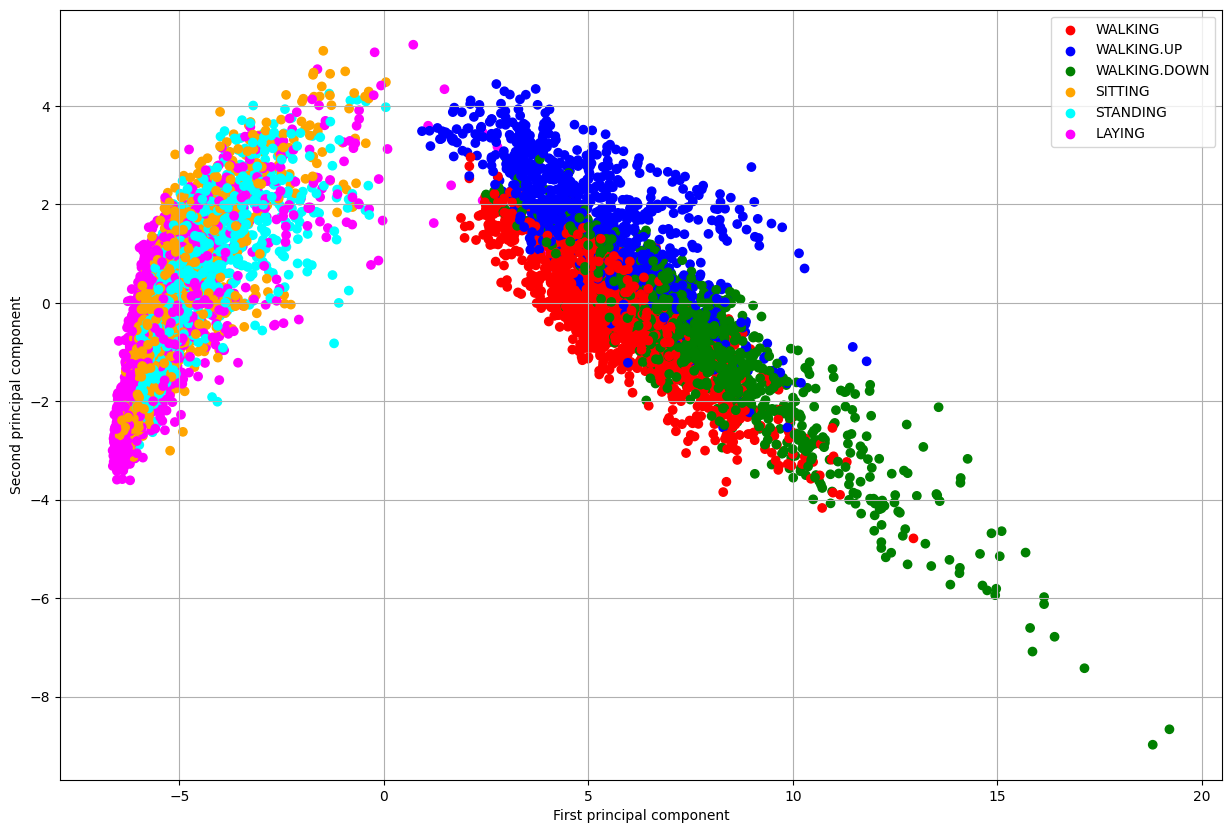

In [311]:
plt.figure(figsize=(15, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [312]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [315]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 128, 9), (2947, 128, 9), (7352, 1), (2947, 1))

In [313]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913989 0.39567083
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [332]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape((-1,)), dtype=torch.long)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape((-1,)),  dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape

(torch.Size([7352, 128, 9]),
 torch.Size([7352]),
 torch.Size([2947, 128, 9]),
 torch.Size([2947]))

In [393]:
class ModelLSTM(nn.Module):
    def __init__(self, n_input=9, n_hidden=64, n_classes=6, num_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=n_input,
                            hidden_size=n_hidden,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.,
                            bidirectional=bidirectional)
        self.fc = nn.Linear(n_hidden * (2 if bidirectional else 1), n_classes)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        if self.bidirectional:
            last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last_hidden = h_n[-1]
        logits = self.fc(last_hidden)
        return logits

In [387]:
n_input = X_train_t.shape[2]
n_classes = len(np.unique(y_train))

model = ModelLSTM(n_input=n_input,
                  n_hidden=64,
                  n_classes=n_classes,
                  num_layers=2,
                  bidirectional=True,
                  dropout=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [388]:
losses_train = []
losses_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    train_tqdm = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{epochs}")
    for xb, yb in train_tqdm:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        batch_size = yb.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

        train_tqdm.set_postfix(loss=running_loss / total, acc=correct / total)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            batch_size = yb.size(0)
            test_loss += loss.item() * batch_size
            test_total += batch_size

            preds = logits.argmax(dim=1)
            test_correct += (preds == yb).sum().item()

    test_loss /= test_total
    test_acc = test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
          f"test_loss={test_loss:.4f}, test_acc={test_acc:.3f}")
    
    losses_train.append(train_loss)
    losses_test.append(test_loss)

Epoch 1/20 | train_loss=1.2192, train_acc=0.492 | test_loss=1.0995, test_acc=0.548


Epoch 2/20 | train_loss=0.8342, train_acc=0.619 | test_loss=0.7333, test_acc=0.658


Epoch 3/20 | train_loss=0.7891, train_acc=0.658 | test_loss=1.0120, test_acc=0.510


Epoch 4/20 | train_loss=0.8444, train_acc=0.632 | test_loss=0.9517, test_acc=0.575


Epoch 5/20 | train_loss=0.7521, train_acc=0.679 | test_loss=0.7959, test_acc=0.672


Epoch 6/20 | train_loss=0.6733, train_acc=0.719 | test_loss=0.6850, test_acc=0.741


Epoch 7/20 | train_loss=0.5521, train_acc=0.782 | test_loss=0.7213, test_acc=0.714


Epoch 8/20 | train_loss=0.4932, train_acc=0.816 | test_loss=0.5872, test_acc=0.782


Epoch 9/20 | train_loss=0.3602, train_acc=0.869 | test_loss=0.5261, test_acc=0.802


Epoch 10/20 | train_loss=0.2929, train_acc=0.896 | test_loss=0.4357, test_acc=0.850


Epoch 11/20 | train_loss=0.2638, train_acc=0.905 | test_loss=0.3525, test_acc=0.879


Epoch 12/20 | train_loss=0.2156, train_acc=0.919 | test_loss=0.3833, test_acc=0.870


Epoch 13/20 | train_loss=0.1962, train_acc=0.927 | test_loss=0.4087, test_acc=0.876


Epoch 14/20 | train_loss=0.1751, train_acc=0.937 | test_loss=0.3335, test_acc=0.883


Epoch 15/20 | train_loss=0.1783, train_acc=0.932 | test_loss=0.3751, test_acc=0.871


Epoch 16/20 | train_loss=0.1690, train_acc=0.938 | test_loss=0.3269, test_acc=0.884


Epoch 17/20 | train_loss=0.1545, train_acc=0.944 | test_loss=0.3418, test_acc=0.885


Epoch 18/20 | train_loss=0.1496, train_acc=0.941 | test_loss=0.2655, test_acc=0.901


Epoch 19/20 | train_loss=0.1454, train_acc=0.943 | test_loss=0.2574, test_acc=0.900


Epoch 20/20 | train_loss=0.1384, train_acc=0.946 | test_loss=0.2373, test_acc=0.908


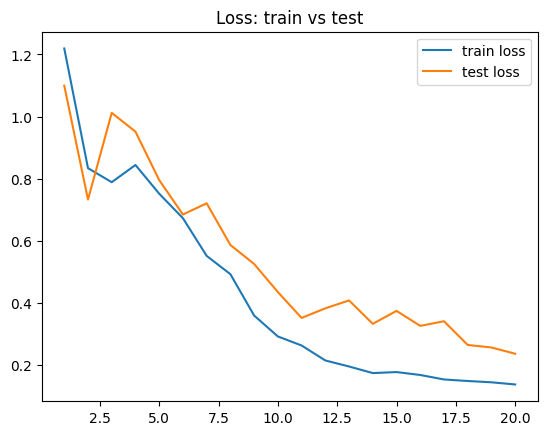

In [392]:
plt.plot(range(1, epochs + 1), losses_train, label="train loss")
plt.plot(range(1, epochs + 1), losses_test, label="test loss")
plt.legend()
plt.title("Loss: train vs test");

#### Выводы

Создал двунаправленный LSTM модель. Попробовал с разными гиперпараметрами. Наилучший результат получил с 2 слоями и 64 нейронами. Добавил Dropout с параметром 0.5, чтобы снизить переобучение. Обучал 20 эпох. Получил на тесте около 90%. Результаты видны на графиках.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [208]:
import os
import random
from PIL import Image
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms.v2 as tfs_v2

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [222]:
class DogDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None, one_hot=True, n_classes=50):
        self.path = os.path.join(path, "train" if train else "test")
        self.train = train
        self.transform = transform
        self.one_hot = one_hot

        self.length = 0
        self.files = []
        if one_hot:
            self.targets = torch.eye(n_classes)
        
        if train:
            folders = [int(i) for i in os.listdir(self.path)]
            folders.sort()
            for folder in folders:
                path = os.path.join(self.path, str(folder))
                list_files = os.listdir(path)
                self.length += len(list_files)
                self.files.extend(map(lambda x: (os.path.join(path, x), folder), list_files))
            self.classes = np.array(folders)
        else:
            list_files = os.listdir(self.path)
            self.length += len(list_files)
            self.files.extend(map(lambda x: (os.path.join(self.path, x), x), list_files))
 
    def __getitem__(self, item):
        path_file, target = self.files[item]
        if self.one_hot and self.train:
            target = self.targets[target].to(device)
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img).to(device)
 
        return img, target
 
    def __len__(self):
        return self.length

In [191]:
resnet_weights = models.ResNet152_Weights.DEFAULT
transforms = resnet_weights.transforms().to(device)
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [192]:
d_train_all = DogDataset(r"data_dogs", transform=transforms)

d_train, d_val = data.random_split(d_train_all, [0.9, 0.1])

train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)
train_data_val = data.DataLoader(d_val, batch_size=32, shuffle=True)

In [193]:
len(d_train), len(d_val)

(6450, 716)

In [194]:
classes = d_train_all.classes
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

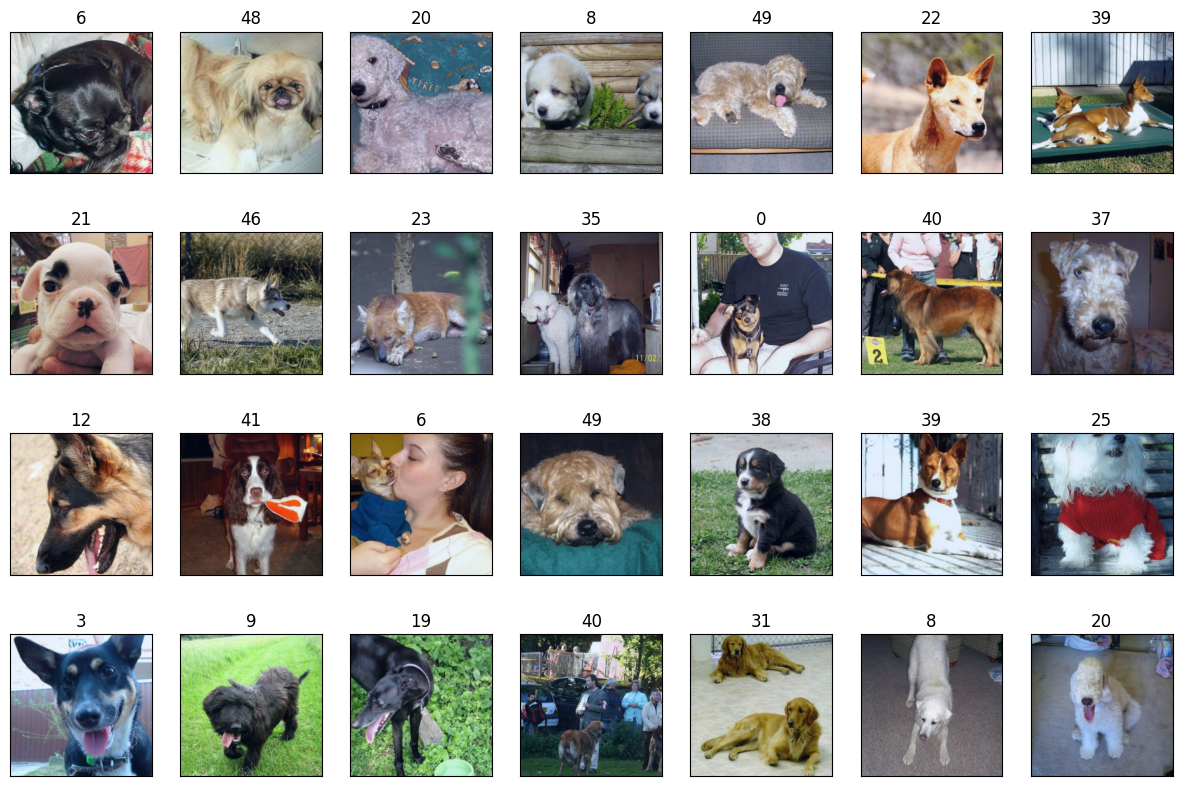

In [195]:
f = plt.figure(figsize=(15, 10))

count = 28
inds = random.sample(range(0, len(d_train)), k=count)
k = 1
for i in inds:
    plt.subplot(4, 7, k)
    k += 1
    
    img, t = d_train[i]
    
    t = classes[t.cpu().numpy().argmax()]
    
    img = img.cpu().permute(1, 2, 0)
    low, hi = torch.amin(img), torch.amax(img)
    img = (img - low) / (hi - low) * 255.0
    
    plt.xticks([])
    plt.yticks([])
    plt.title(t)
    plt.imshow(img.numpy().astype('uint8'))

In [196]:
model = models.resnet152(weights=resnet_weights).to(device)
model.requires_grad_(False)
print()

In [197]:
model.fc = nn.Linear(2048, 50).to(device)
model.fc.requires_grad_(True)

Linear(in_features=2048, out_features=50, bias=True)

In [198]:
all(p.is_cuda for p in model.parameters())

True

In [199]:
optimizer = optim.Adam(params=model.fc.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 5

In [200]:
loss_lst = []
loss_lst_val = []

for _e in range(epochs):
    model.train()
    
    loss_mean = 0
    lm_count = 0

    correct = 0
    total = 0
 
    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        
        predicted = torch.argmax(predict, dim=1)        
        correct += (predicted == torch.argmax(predict, dim=1)).sum().item()
        
        total += y_train.size(0)
        accuracy = correct / total
        
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}, acc={accuracy:.3f}")

    if train_data_val:
        model.eval()
        Q_val = 0
        count_val = 0

        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for x_val, y_val in train_data_val:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                
                p = model(x_val)
                loss = loss_function(p, y_val)
                Q_val += loss.item()
                count_val += 1

                predicted_val = torch.argmax(p, dim=1)
                correct_val += (predicted_val == torch.argmax(y_val, dim=1)).sum().item()
                total_val += y_val.size(0)
    
        Q_val /= count_val
        accuracy_val = correct_val / total_val
    
        loss_lst.append(loss_mean)
        loss_lst_val.append(Q_val)
    
        print(f" | Train_loss={loss_mean:.3f}, Train_accuracy={accuracy:.3f}, Val_loss={Q_val:.3f}, Val_accuracy={accuracy_val:.3f}")

Epoch [1/5], loss_mean=1.679, acc=1.000: 100%|███████████████████████████████████████| 202/202 [01:25<00:00,  2.37it/s]


 | Train_loss=1.679, Train_accuracy=1.000, Val_loss=0.619, Val_accuracy=0.951


Epoch [2/5], loss_mean=0.379, acc=1.000: 100%|███████████████████████████████████████| 202/202 [01:23<00:00,  2.41it/s]


 | Train_loss=0.379, Train_accuracy=1.000, Val_loss=0.324, Val_accuracy=0.962


Epoch [3/5], loss_mean=0.216, acc=1.000: 100%|███████████████████████████████████████| 202/202 [01:24<00:00,  2.40it/s]


 | Train_loss=0.216, Train_accuracy=1.000, Val_loss=0.236, Val_accuracy=0.965


Epoch [4/5], loss_mean=0.162, acc=1.000: 100%|███████████████████████████████████████| 202/202 [01:24<00:00,  2.40it/s]


 | Train_loss=0.162, Train_accuracy=1.000, Val_loss=0.201, Val_accuracy=0.966


Epoch [5/5], loss_mean=0.128, acc=1.000: 100%|███████████████████████████████████████| 202/202 [01:24<00:00,  2.40it/s]


 | Train_loss=0.128, Train_accuracy=1.000, Val_loss=0.188, Val_accuracy=0.966


In [201]:
loss_lst, loss_lst_val

([1.6790267949057114,
  0.37879705488091653,
  0.2156228726305584,
  0.1615214931714064,
  0.1275959549711482],
 [0.6190397583920023,
  0.3239765581877335,
  0.23629879303600476,
  0.20107828307410944,
  0.18837085074704626])

In [203]:
train_data_all = data.DataLoader(d_train_all, batch_size=32, shuffle=True)

resnet_weights = models.ResNet152_Weights.DEFAULT
transforms = resnet_weights.transforms().to(device)

model = models.resnet152(weights=resnet_weights).to(device)
model.requires_grad_(False)

model.fc = nn.Linear(2048, 50).to(device)
model.fc.requires_grad_(True)

optimizer = optim.Adam(params=model.fc.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 5

In [204]:
for e in range(epochs):
    model.train()
    
    loss_mean = 0
    lm_count = 0

    correct = 0
    total = 0
 
    train_tqdm = tqdm(train_data_all, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        
        predicted = torch.argmax(predict, dim=1)        
        correct += (predicted == torch.argmax(predict, dim=1)).sum().item()
        
        total += y_train.size(0)
        accuracy = correct / total
        
        train_tqdm.set_description(f"Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f}, acc={accuracy:.3f}")

Epoch [5/5], loss_mean=0.124, acc=1.000: 100%|███████████████████████████████████████| 224/224 [01:31<00:00,  2.45it/s]


In [205]:
st = model.state_dict()
torch.save(st, 'dogs_model_transfer_resnet152.tar')

In [248]:
d_test = DogDataset(r"data_dogs", train=False, transform=transforms)
test_data = data.DataLoader(d_test, batch_size=1, shuffle=False)

In [249]:
len(d_test)

1503

In [250]:
for i in test_data:
    break

In [253]:
i[0].shape

torch.Size([1, 3, 224, 224])

In [257]:
res = {}
model.eval()
test_tqdm = tqdm(test_data, leave=True)
for x_test, filename in test_tqdm:
    with torch.no_grad():
        p = model(x_test)
        p2 = torch.argmax(p, dim=1)
        res[filename[0]] = p2[0].item()

100%|██████████████████████████████████████████████████████████████████████████████| 1503/1503 [01:17<00:00, 19.34it/s]


In [272]:
df = pd.DataFrame.from_dict(res, orient='index').reset_index()
df.columns = ['filename', 'prediction']
df

,filename,prediction
0,0.jpeg,42
1,1.jpeg,3
2,10.jpeg,39
3,100.jpeg,18
4,1000.jpeg,35
...,...,...
1498,995.jpeg,7
1499,996.jpeg,6
1500,997.jpeg,45
1501,998.jpeg,22


In [277]:
df.to_csv("dogs_test_answers.csv", index=False)

#### Выводы

Для классификации взял уже готовую сеть ResNet152 и дооубучал ещё 5 эпохов. Сперва отделил десятую часть как валидационную и получил на валидационной выборке окол 96-97% точности, а потом обучал снова на тех же параметрах, но уже весь датасет. На тестовых изображений предполагаю точность будет не ниже 96%. Сохранил результат в нужном виде в файле csv.

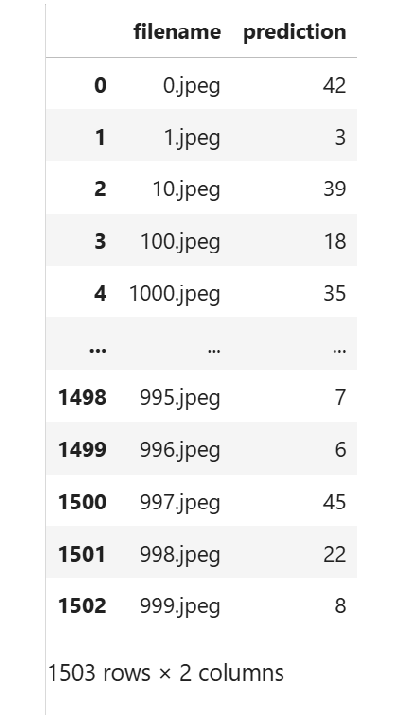